# Project Overview

Welcome to our British Airways Customer Experience Enhancement Project! At British Airways, we understand that every day, thousands of valued customers embark on journeys with us, entrusting us with their travel experiences. To ensure we consistently elevate these experiences, we engage in a continuous process of analyzing and understanding customer feedback.

In this dynamic project, we are set to leverage cutting-edge web scraping technology to gather valuable insights from customer reviews. Our aim is to harness the wealth of information shared by our passengers and transform it into actionable strategies for further enhancing their journeys.

Through meticulous analysis, we will delve into the nuances of customer sentiments, preferences, and suggestions. This detailed examination will serve as the foundation for identifying key areas of improvement and innovation. By mining the wealth of feedback collected through web scraping, we aspire to gain a deeper understanding of the intricacies of our customers' experiences.

The ultimate goal is clear — to utilize the power of data and insights to elevate our services, addressing the specific needs and desires of our passengers. Join us on this journey as we embark on a mission to not only meet but exceed the expectations of our esteemed customers, ensuring that every trip with British Airways becomes an unforgettable and seamlessly delightful experience.

# Data Collection

In [35]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []
item_info = {'reviews':[],
             'type_of_traveller':[],
             'seat_type':[],
             'route':[],
             'date_flown':[],
             'seat_comfort':[],
             'cabin_staff_service':[],
             'food_and_beverages':[],
             'inflight_entertainment':[],
             'ground_service':[],
             'wifi_and_connectivity':[],
             'value_for_money':[],
             'recommended':[],
             'aircraft':[]}

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)
    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    # print(parsed_content)

    for para in parsed_content.find_all("div", {"class": "text_content"}):
        item_info['reviews'].append(para.get_text())

    for rating in parsed_content.find_all("div",{"class":"review-stats"}):
      table = rating.find('table', class_='review-ratings')
      rows = table.find_all('tr')

      temp_dic = {
             'type_of_traveller':'',
             'seat_type':'',
             'route':'',
             'date_flown':'',
             'seat_comfort':0,
             'cabin_staff_service':0,
             'food_and_beverages':0,
             'inflight_entertainment':0,
             'ground_service':0,
             'wifi_and_connectivity':0,
             'value_for_money':0,
             'recommended':'',
             'aircraft':''}
      for row in rows:
        item_name = row.find('td', class_='review-rating-header').text.strip()
        item_name = item_name.lower()
        item_name = item_name.replace(" ","_").replace("&","and")

        value_element = row.find('td', class_='review-value')

        if value_element is None:
          rating_elements = row.find_all('span', class_='star fill')
          rating = len(rating_elements)
          temp_dic[item_name] = rating
        else:
          temp_dic[item_name] = value_element.text.strip()

      for key,value in temp_dic.items():
        item_info[key].append(value)

    print(item_info)

Scraping page 1
{'reviews': ['✅ Trip Verified | Not a great experience. I could not check in online as two separate parts of the BA computer system do not talk to each other. At LHR a delightful check in clerk sorted it quickly, manually! We boarded on time, but luggage loading had to be halted as the Captain spotted a technical issue and an engineer was called. By the time it was sorted we had missed our slot so took off an hour behind schedule. The flight was uneventful, but the plane had clearly seen better days, legroom was appalling and the handout of a small bottle of water and a soggy cookie made one wish for the days when flying BA meant something special. Next time it will be Jet2.', "Not Verified | I was excited to fly BA as I'd not travelled with them long haul for over 25yrs. I've travelled to Australia on many occasions, so I've pretty much travelled with them all. Terrible was my experience. BA have become the Ryanair of long-haul travel, riding on their previous good nam

In [3]:
for key, value in item_info.items():
    print(key,len(value))

reviews 1000
type_of_traveller 1000
seat_type 1000
route 1000
date_flown 1000
seat_comfort 1000
cabin_staff_service 1000
food_and_beverages 1000
inflight_entertainment 1000
ground_service 1000
wifi_and_connectivity 1000
value_for_money 1000
recommended 1000
aircraft 1000


In [4]:
df = pd.DataFrame(item_info)

In [5]:
df

reviews type_of_traveller  \
0    ✅ Trip Verified | Not a great experience. I co...    Couple Leisure   
1    Not Verified | I was excited to fly BA as I'd ...    Family Leisure   
2    Not Verified |  I just want to warn everyone o...    Family Leisure   
3    Not Verified | Paid for business class travell...    Family Leisure   
4    ✅ Trip Verified |  The plane was extremely dir...    Family Leisure   
..                                                 ...               ...   
995  ✅ Trip Verified |  London to Seoul. I normally...          Business   
996  ✅ Trip Verified |  London Heathrow to New York...    Family Leisure   
997  ✅ Trip Verified | San Diego to London. From th...    Couple Leisure   
998  ✅ Trip Verified |  Gatwick to St Lucia. Flew B...          Business   
999  ✅ Trip Verified |  London to Chennai. It was a...      Solo Leisure   

           seat_type                            route     date_flown  \
0      Economy Class        London Heathrow to Lisbon   January 2024   
1      Economy Class              London to Hong Kong   January 2024   
2     Business Class  Dusseldorf (DUS) to Miami (MIA)   January 2024   
3     Business Class         Cairo to London Heathrow   January 2024   
4      Economy Class       Dublin  to London Heathrow   January 2024   
..               ...                              ...            ...   
995  Premium Economy                  London to Seoul  February 2019   
996  Premium Economy           London to New York JFK  February 2019   
997   Business Class              San Diego to London  February 2019   
998   Business Class              Gatwick to St Lucia  February 2019   
999    Economy Class                London to Chennai     March 2018   

     seat_comfort  cabin_staff_service  food_and_beverages  \
0               1                    4                   1   
1               1                    3                   1   
2               1                    1                   0   
3               1                    1                   1   
4               3                    3                   0   
..            ...                  ...                 ...   
995             5                    4                   3   
996             4                    5                   4   
997             4                    1                   2   
998             4                    4                   4   
999             5                    5                   5   

     inflight_entertainment  ground_service  wifi_and_connectivity  \
0                         0               3                      0   
1                         1               1                      1   
2                         0               1                      0   
3                         0               1                      0   
4                         0               1                      1   
..                      ...             ...                    ...   
995                       3               2                      0   
996                       5               5                      3   
997                       0               4                      0   
998                       4               3                      0   
999                       5               5                      5   

     value_for_money recommended        aircraft  
0                  4          no            A320  
1                  2          no                  
2                  1          no                  
3                  1          no                  
4                  3          no                  
..               ...         ...             ...  
995                4         yes    Boeing 787-9  
996                4         yes  Boeing 747-400  
997                2          no                  
998                3         yes      Boeing 777  
999                5         yes                  

[1000 rows x 14 columns]

# Data Processing
As we can see here, presence of inconsistencies in the dataset, making it challenging for straightforward analysis. I will initiate processing steps to unravel meaningful insights from the data.

1. Transform numerical categories to enable the model to recognize and decipher patterns effectively.

2. Customer Ratings Exploration.

3. Data cleansing techniques to eliminate unnecessary or irrelevant information and enhance the quality of the dataset for more accurate and reliable analysis.

In [8]:
df['sentiment'] = df['recommended'].apply(lambda x: 'Positive' if x == 'yes' else 'Negative')


In [9]:
df

reviews type_of_traveller  \
0    ✅ Trip Verified | Not a great experience. I co...    Couple Leisure   
1    Not Verified | I was excited to fly BA as I'd ...    Family Leisure   
2    Not Verified |  I just want to warn everyone o...    Family Leisure   
3    Not Verified | Paid for business class travell...    Family Leisure   
4    ✅ Trip Verified |  The plane was extremely dir...    Family Leisure   
..                                                 ...               ...   
995  ✅ Trip Verified |  London to Seoul. I normally...          Business   
996  ✅ Trip Verified |  London Heathrow to New York...    Family Leisure   
997  ✅ Trip Verified | San Diego to London. From th...    Couple Leisure   
998  ✅ Trip Verified |  Gatwick to St Lucia. Flew B...          Business   
999  ✅ Trip Verified |  London to Chennai. It was a...      Solo Leisure   

           seat_type                            route     date_flown  \
0      Economy Class        London Heathrow to Lisbon   January 2024   
1      Economy Class              London to Hong Kong   January 2024   
2     Business Class  Dusseldorf (DUS) to Miami (MIA)   January 2024   
3     Business Class         Cairo to London Heathrow   January 2024   
4      Economy Class       Dublin  to London Heathrow   January 2024   
..               ...                              ...            ...   
995  Premium Economy                  London to Seoul  February 2019   
996  Premium Economy           London to New York JFK  February 2019   
997   Business Class              San Diego to London  February 2019   
998   Business Class              Gatwick to St Lucia  February 2019   
999    Economy Class                London to Chennai     March 2018   

     seat_comfort  cabin_staff_service  food_and_beverages  \
0               1                    4                   1   
1               1                    3                   1   
2               1                    1                   0   
3               1                    1                   1   
4               3                    3                   0   
..            ...                  ...                 ...   
995             5                    4                   3   
996             4                    5                   4   
997             4                    1                   2   
998             4                    4                   4   
999             5                    5                   5   

     inflight_entertainment  ground_service  wifi_and_connectivity  \
0                         0               3                      0   
1                         1               1                      1   
2                         0               1                      0   
3                         0               1                      0   
4                         0               1                      1   
..                      ...             ...                    ...   
995                       3               2                      0   
996                       5               5                      3   
997                       0               4                      0   
998                       4               3                      0   
999                       5               5                      5   

     value_for_money recommended        aircraft sentiment  
0                  4          no            A320  Negative  
1                  2          no                  Negative  
2                  1          no                  Negative  
3                  1          no                  Negative  
4                  3          no                  Negative  
..               ...         ...             ...       ...  
995                4         yes    Boeing 787-9  Positive  
996                4         yes  Boeing 747-400  Positive  
997                2          no                  Negative  
998                3         yes      Boeing 777  Positive  
999         

In [10]:
mean_ratings = df[['seat_comfort', 'cabin_staff_service', 'food_and_beverages', 'inflight_entertainment', 'ground_service','wifi_and_connectivity']].mean()


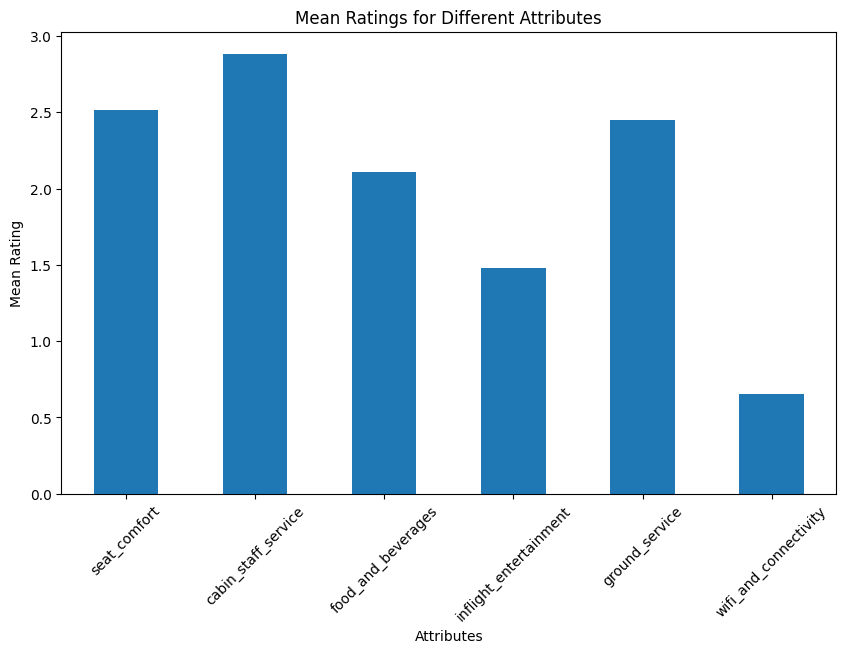

In [11]:
plt.figure(figsize=(10, 6))
mean_ratings.plot(kind='bar', rot=45)
plt.title('Mean Ratings for Different Attributes')
plt.xlabel('Attributes')
plt.ylabel('Mean Rating')
plt.show()

In [12]:
aircraft_ratings = df.groupby('aircraft')[['seat_comfort', 'cabin_staff_service', 'food_and_beverages', 'inflight_entertainment', 'ground_service']].mean()


In [13]:
traveler_type_ratings = df.groupby('type_of_traveller')[['seat_comfort', 'cabin_staff_service', 'food_and_beverages', 'inflight_entertainment', 'ground_service']].mean()


<Figure size 2000x1000 with 0 Axes>

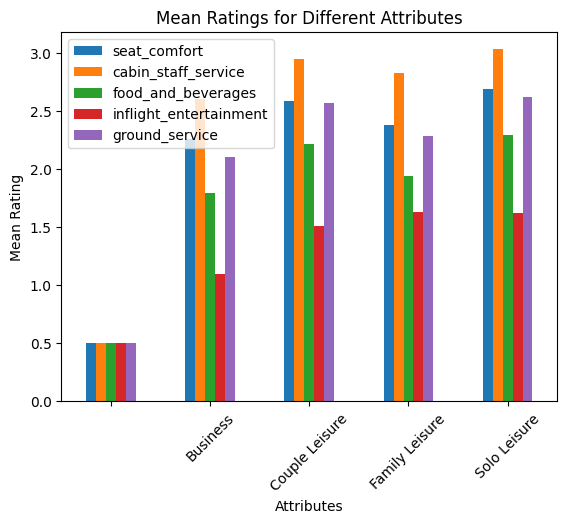

In [14]:
plt.figure(figsize=(20, 10))
traveler_type_ratings.plot(kind='bar', rot=45)
plt.title('Mean Ratings for Different Attributes')
plt.xlabel('Attributes')
plt.ylabel('Mean Rating')
plt.show()

Here we can see how type of travellers rate variois amenities.

In [16]:
negative_reviews = df[df['sentiment'] == 'Negative']

stop_words = set(stopwords.words('english'))

# common_issues = negative_reviews['reviews'].str.lower().str.split().explode().value_counts().head(10)
common_issues = (
    negative_reviews['reviews']
    .str.lower()
    .str.split()
    .explode()
    .apply(lambda x: x.strip(".,!?"))
    .apply(lambda x: x if x not in stop_words else None)  # Filter out stop words
    .dropna()  # Remove None values
    .value_counts()
    .head(20)
)

In [17]:
common_issues

flight      1296
ba           864
verified     671
|            668
trip         585
✅            500
service      480
london       376
us           327
british      321
one          321
airways      309
hours        303
get          301
seat         299
class        296
staff        291
business     288
would        284
time         279
Name: reviews, dtype: int64

In [18]:
recommendation_percentage = df['recommended'].value_counts(normalize=True) * 100


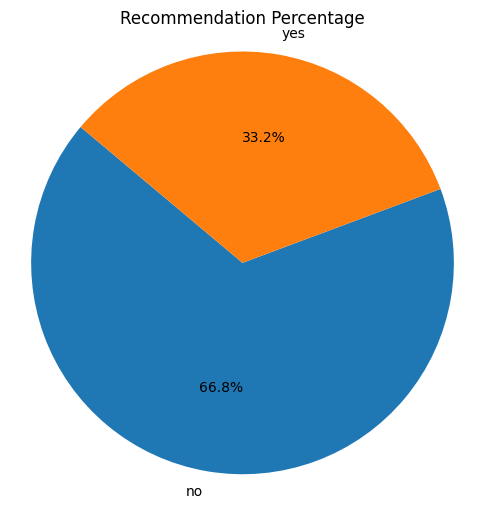

In [19]:
import matplotlib.pyplot as plt

# Assuming you have recommendation_percentage calculated as you mentioned
# recommendation_percentage = df['recommended'].value_counts(normalize=True) * 100

# Create a pie chart to visualize the recommendation percentages
plt.figure(figsize=(6, 6))
plt.pie(recommendation_percentage, labels=recommendation_percentage.index, autopct='%1.1f%%', startangle=140)
plt.title('Recommendation Percentage')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.show()

In [21]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# The provided text
text = "✅ Trip Verified | The worst airline I have ever flown with. Allocated the very back row next to the toilets and galley. No chance of getting any sleep, question asked of possible seat movement ignored and getting bumped the entire time by cabin crew walking or pushing kart up and down aisle without one apology. Would have been better sitting in the luggage compartment."

# Use VADER to analyze sentiment
sentiment = analyzer.polarity_scores(text)

# Get the negative words based on the VADER analysis
negative_words = [(word,analyzer.polarity_scores(word)) for word in text.split()]



In [24]:
def preprocess_text(text):
    # Define the stop words to be excluded, excluding "not" and "never"
    excluded_stopwords = set(stopwords.words('english')) - set(["not", "never"])

    # Remove checkmark (✅)
    text = re.sub(r'✅', '', text)

    # Remove "Trip Verified |"
    text = text.replace("Trip Verified |", "")
    text = text.replace("Not Verified |", "")

    # Tokenize the text
    words = word_tokenize(text)

    # Remove common English stop words (excluding "not" and "never")
    filtered_words = [word for word in words if word.lower() not in excluded_stopwords]

    # Reconstruct the text
    text = ' '.join(filtered_words)

    # Remove any remaining special characters and extra spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(' +', ' ', text).strip()

    return text

# Original text


In [27]:
df['reviews'] = df['reviews'].apply(preprocess_text)

# Feature Engineering

In [28]:
X = df.reviews
target = df.recommended

In [29]:
y = [1 if target == "yes" else 0 for target in target]


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [31]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=None)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model Training

In [32]:
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [33]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = logistic_regression.coef_


In [41]:
top_10_words_indices = np.argsort(coefficients[0])[-20:]
top_10_words = [feature_names[i] for i in top_10_words_indices]


In [42]:
top_10_words

['new',
 'amazing',
 'early',
 'quite',
 'quick',
 'pleasant',
 'best',
 'club',
 'nice',
 'professional',
 'efficient',
 'time',
 'well',
 'crew',
 'thank',
 'excellent',
 'great',
 'comfortable',
 'friendly',
 'good']

# Positive Remarks

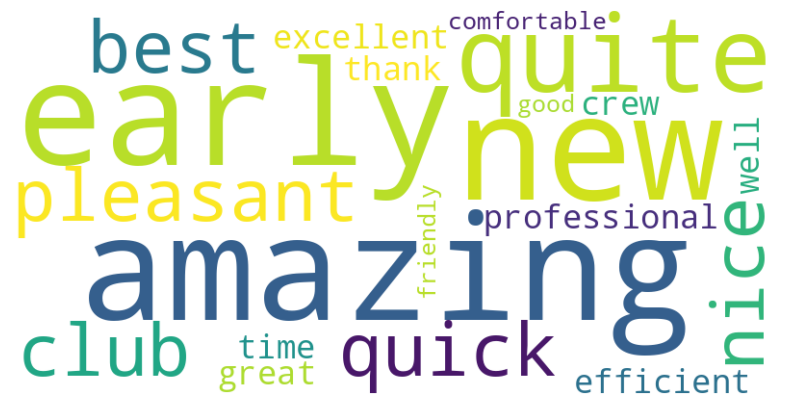

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine the top words into a single string
text = " ".join(top_10_words)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Negative Remarks

In [43]:
negative_indices = np.argsort(coefficients[0])[:20]
negative_words = [feature_names[i] for i in negative_indices]


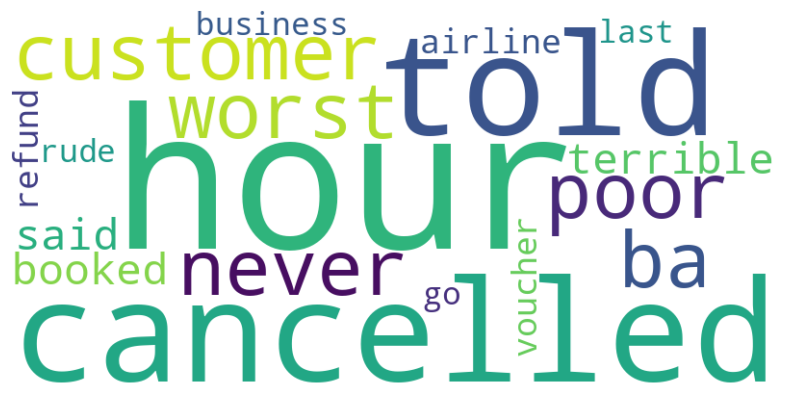

In [44]:
# Combine the top words into a single string
text = " ".join(negative_words)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()